Hunter Bennett  
Glass Lab  
Created 180205 | Last updated 180205  
____________  
here we are seeking to understand if there are noticeable molecular phenotype within 4 weeks on the NASH diet.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image
import subprocess
import os
import sys
import glob
import re

# import user defined packages
sys.path.insert(0, '/home/h1bennet/scripts')
import hbUtils

# plot matplotlib plots in notebook
%matplotlib inline

# load extension for running R from python
#  %load_ext rpy2.ipython

sns.set(font_scale=1)
sns.set_context('talk')
sns.set_style('white')

Make output directory

In [2]:
# define output directory
outdir = '/home/h1bennet/liverStrains/results/180517_RNASeq_NASH_Timecourse/'
if not os.path.isdir(outdir):
    subprocess.call(['mkdir', outdir])

In [3]:
# set working directory
workingDirectory = '/home/h1bennet/liverStrains/results/180517_RNASeq_NASH_Timecourse/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)

In [4]:
# import mm10 to refseq id gene mapper
mm10_refseq = pd.read_csv('/home/h1bennet/lxr/data/mm10_refseq_genename.txt', sep='\t', names=['refseq_id', 'gene'], index_col=0)

Set some user defined functions

In [5]:
def tpm_paired_scatter(tpm, strain, tissue):
    tmp_df = hbUtils.df_col_subset(tpm, strain + '.*' + tissue)
    tmp_df.columns = pd.Series(tmp_df.columns).str.extract('[_-]([a-zA-Z]+[0-9]+[a-zA-Z]{0,2})[_-]',
                                                                   flags=re.IGNORECASE, expand=False)
    tmp_df.columns = pd.Series(tmp_df.columns).replace(np.nan, 'NNaF')
    g = sns.PairGrid(np.log2(tmp_df + 1))
    g = g.map(plt.scatter)
    corrs = np.log(tmp_df + 1).corr().values.flatten()
    for ax, corrval in zip(g.axes.flat, corrs):
        ax.text(0, 16, "r = %.2f" % corrval, fontsize=9)

            
# define function for labeling points in scatterplots
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']))


### Do Some RNA QC

In [6]:
%%bash
if [ ! -d ./qc_rna_liver/ ]; then mkdir ./qc_rna_liver; fi

In [7]:
# make summary table of qc stats
qc_stats = pd.DataFrame()

for sample in os.listdir('./tag_directories_rna_liver/'):
    # pull tag information from HOMER output file
    tag_info_df = pd.read_table('./tag_directories_rna_liver/'+sample+'/tagInfo.txt', sep='\t')
    qc_stats.loc[sample, 'uniquePositions'] = int(tag_info_df.iloc[0, 1])
    qc_stats.loc[sample, 'fragmentLengthEstimate'] = int(tag_info_df.iloc[1, 0].split('=')[1])
    qc_stats.loc[sample, 'tagsPerBP'] = float(tag_info_df.iloc[3, 0].split('=')[1])
    qc_stats.loc[sample, 'clonality'] = float(tag_info_df.iloc[4, 0].split('=')[1])
    qc_stats.loc[sample, 'GC_Content'] = float(tag_info_df.iloc[7, 0].split('=')[1])
    # f = open('./tag_directories_atac/'+sample+'/'+sample+'.mm10.bowtie2.log')
    # get mapping stats from bowtie log
    for file in os.listdir('./tag_directories_rna_liver/'+sample+'/'):
        if file.endswith(".log"):
            f = open('./tag_directories_rna_liver/'+sample+'/'+file)
            txt = f.read()
            star_log = list(filter(None, re.split('\s|\|',txt)))
            qc_stats.loc[sample, 'totalReads'] =int(star_log[29])
            qc_stats.loc[sample, 'uniquelyMappedReads'] = int(star_log[41])
            qc_stats.loc[sample, 'multiMappedReads'] = int(star_log[115])
            qc_stats.loc[sample, 'frac_unmappedReads_mismatch'] = float(star_log[151].strip('%'))/100
            qc_stats.loc[sample, 'frac_unmappedReads_short'] = float(star_log[158].strip('%'))/100
            qc_stats.loc[sample, 'frac_unmappedReads_other'] = float(star_log[164].strip('%'))/100
            qc_stats.loc[sample, 'uniquelyMappedFraction'] = \
                                                    qc_stats.loc[sample, 'uniquelyMappedReads'] \
                                                    / qc_stats.loc[sample, 'totalReads']
            qc_stats.loc[sample, 'mappedFraction'] = 1 \
                                            - qc_stats.loc[sample, 'frac_unmappedReads_other'] \
                                            - qc_stats.loc[sample, 'frac_unmappedReads_short'] \
                                            - qc_stats.loc[sample, 'totalReads']
    if not any(fname.endswith('.log') for fname in os.listdir('./tag_directories_rna_liver/'+sample+'/')):
        print(sample + ' does not contain a mapping log file')
        qc_stats.loc[sample, 'totalReads'] = np.nan
        qc_stats.loc[sample, 'uniquelyMappedReads'] = np.nan
        qc_stats.loc[sample, 'multiMappedReads'] = np.nan
        qc_stats.loc[sample, 'frac_unmappedReads_mismatch'] = np.nan
        qc_stats.loc[sample, 'frac_unmappedReads_short'] = np.nan
        qc_stats.loc[sample, 'frac_unmappedReads_other'] = np.nan
        qc_stats.loc[sample, 'uniquelyMappedFraction'] = np.nan
        qc_stats.loc[sample, 'mappedFraction'] = np.nan

qc_stats.sort_index(inplace=True)
qc_stats.to_csv('./qc_rna_liver/mapping_stats.tsv', sep='\t')

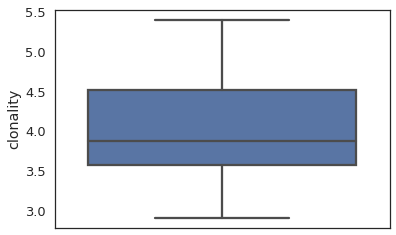

In [29]:
# clonality boxplot
fig = sns.boxplot(y=qc_stats['clonality']).get_figure()
fig.savefig('./qc_rna_liver/clonality_boxplot_hb.pdf', bbox_inches='tight')

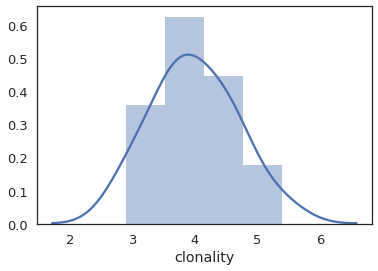

In [30]:
# clonality distplot
fig = sns.distplot(qc_stats['clonality']).get_figure()
fig.savefig('./qc_rna_liver/clonality_distplot_hb.pdf', bbox_inches='tight')

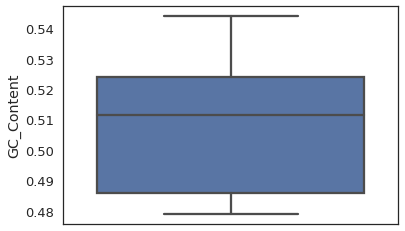

In [31]:
# GC_Content boxplot
fig = sns.boxplot(y=qc_stats['GC_Content']).get_figure()
fig.savefig('./qc_rna_liver/GC_Content_boxplot_hb.pdf', bbox_inches='tight')

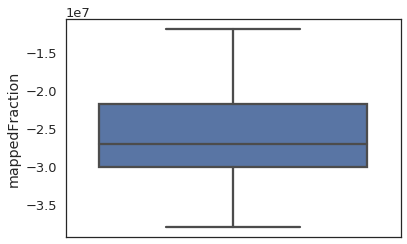

In [32]:
# mapped fraction boxplot
fig = sns.boxplot(y=qc_stats['mappedFraction']).get_figure()
fig.savefig('./qc_rna_liver/mappedFraction_boxplot_hb.pdf', bbox_inches='tight')

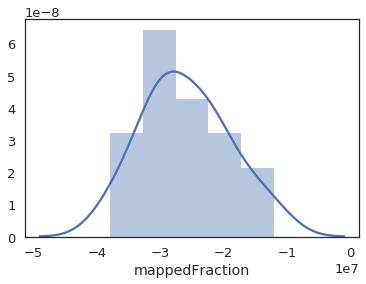

In [33]:
# mapped fraction distplot
fig = sns.distplot(qc_stats['mappedFraction'].dropna()).get_figure()
fig.savefig('./qc_rna_liver/mappedFraction_distplot_hb.pdf', bbox_inches='tight')

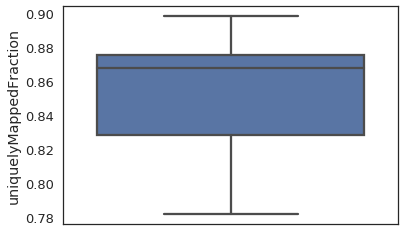

In [34]:
# uniquely Mapped Fraction boxplot
fig = sns.boxplot(y=qc_stats['uniquelyMappedFraction'].dropna()).get_figure()
fig.savefig('./qc_rna_liver/uniquelyMappedFraction_boxplot_hb.pdf', bbox_inches='tight')

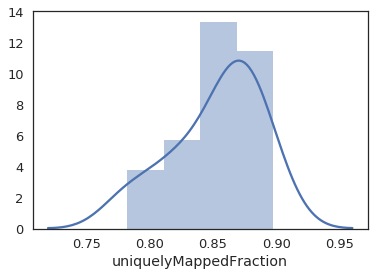

In [35]:
# uniquely Mapped Fraction distplot
fig = sns.distplot(qc_stats['uniquelyMappedFraction'].dropna()).get_figure()
fig.savefig('./qc_rna_liver/uniquelyMappedFraction_distplot_hb.pdf', bbox_inches='tight')

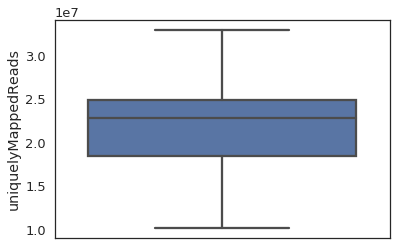

In [36]:
# uniquely Mapped Reads boxplot
fig = sns.boxplot(y=qc_stats['uniquelyMappedReads'].dropna()).get_figure()
fig.savefig('./qc_rna_liver/uniquelyMappedReads_distplot_hb.pdf', bbox_inches='tight')

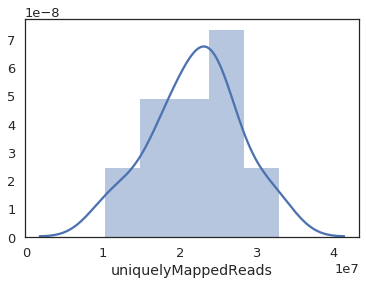

In [37]:
# uniquely Mapped Reads distplot
fig = sns.distplot(qc_stats['uniquelyMappedReads'].dropna()).get_figure()
fig.savefig('./qc_rna_liver/uniquelyMappedReads_distplot_hb.pdf', bbox_inches='tight')

### Generate RNA Seq Files

In [38]:
# %%bash
# # if directories don't exist, create them
# if [ ! -d ./expression_liver/ ]; then mkdir ./expression_liver; fi

# analyzeRepeats.pl rna mm10 -count exons -condenseGenes -raw -d ./tag_directories_rna_liver/* > ./expression_liver/rna_exp_raw.tsv
# analyzeRepeats.pl rna mm10 -count exons -condenseGenes -d ./tag_directories_rna_liver/* > ./expression_liver/rna_exp.tsv
# analyzeRepeats.pl rna mm10 -count exons -condenseGenes -rpkm -d ./tag_directories_rna_liver/* > ./expression_liver/rna_exp_rpkm.tsv

	Tag Directories:
		./tag_directories_rna_liver/NCoRWT_WholeLiver_RNA_AMLNDiet_10week_LN288A
		./tag_directories_rna_liver/NCoRWT_WholeLiver_RNA_AMLNDiet_10week_LN294B
		./tag_directories_rna_liver/NCoRWT_WholeLiver_RNA_AMLNDiet_21week_LN170A
		./tag_directories_rna_liver/NCoRWT_WholeLiver_RNA_AMLNDiet_21week_LN170B
		./tag_directories_rna_liver/NCoRWT_WholeLiver_RNA_AMLNDiet_21week_LN170C
		./tag_directories_rna_liver/NCoRWT_WholeLiver_RNA_AMLNDiet_28week_LN137B
		./tag_directories_rna_liver/NCoRWT_WholeLiver_RNA_AMLNDiet_28week_LN137C
		./tag_directories_rna_liver/NCoRWT_WholeLiver_RNA_AMLNDiet_30week_LN136C
		./tag_directories_rna_liver/NCoRWT_WholeLiver_RNA_AMLNDiet_30week_LN141A
		./tag_directories_rna_liver/NCoRWt_WholeLiver_RNA_ControlDiet_0week_LN59a
		./tag_directories_rna_liver/NCoRWT_WholeLiver_RNA_ControlDiet_21week_LN169A
		./tag_directories_rna_liver/NCoRWT_WholeLiver_RNA_ControlDiet_21week_LN169B
		./tag_directories_rna_liver/NCoRWT_WholeLiver_RNA_ControlDiet_28week_LN14

In [87]:
# %%bash
# makeMultiWigHub.pl hrb_wholeliver_timecourse_hub mm10 -force -d ./tag_directories_rna/*

Process is interrupted.


In [70]:
# %%bash
# source activate rrrr
# getDiffExpression.pl ./expression/rna_exp_raw.tsv 10wk 10wk 21wk 21wk 21wk 28wk 28wk 30wk 30wk 0wk_control 21wk_control 21wk_control 30wk_control 30wk_control 6wk_control 6wk_control 6wk_control 6wk_control -AvsA > ./expression_liver/diff_output.txt




	Differential Expression Program: DESeq2
	Autodetecting input file format...
	Using DESeq2 to calculate differential expression/enrichment...
	Autodetected analyzeRepeats.pl file

	Performing variance stabalization (rlog)...

	Output Stats 10wk vs. 21wk:
		Total Genes: 24537
		Total Up-regulated in 21wk vs. 10wk: 26 (0.106%) [log2fold>1, FDR<0.05]
		Total Dn-regulated in 21wk vs. 10wk: 158 (0.644%) [log2fold<-1, FDR<0.05]
	Output Stats 10wk vs. 28wk:
		Total Genes: 24537
		Total Up-regulated in 28wk vs. 10wk: 931 (3.794%) [log2fold>1, FDR<0.05]
		Total Dn-regulated in 28wk vs. 10wk: 1180 (4.809%) [log2fold<-1, FDR<0.05]
	Output Stats 10wk vs. 30wk:
		Total Genes: 24537
		Total Up-regulated in 30wk vs. 10wk: 847 (3.452%) [log2fold>1, FDR<0.05]
		Total Dn-regulated in 30wk vs. 10wk: 1276 (5.200%) [log2fold<-1, FDR<0.05]
	Output Stats 10wk vs. 0wk_control:
		Total Genes: 24537
		Total Up-regulated in 0wk_control vs. 10wk: 546 (2.225%) [log2fold>1, FDR<0.05]
		Total Dn-regulated in 0wk_

# Import files for analysis and plotting

In [8]:
# import differential gene expression
diff_gene = pd.read_csv('./expression_liver/diff_output.txt', sep='\t', index_col=0)
print(diff_gene.shape)

# create gene name index
diff_gene = diff_gene.merge(mm10_refseq, how='left', left_index=True, right_index=True).drop_duplicates()
diff_gene = diff_gene.reset_index().set_index('gene').drop(columns='index')

# filter entries without a gene
diff_gene = diff_gene.loc[diff_gene.index.notna(), :]
print(diff_gene.shape)

(24537, 109)
(24493, 109)


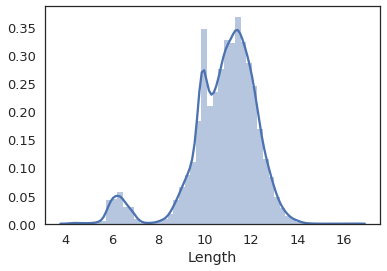

In [9]:
rpkm = pd.read_csv(outdir + './expression_liver/rna_exp_rpkm.tsv', sep='\t')
# set rpkm index
rpkm.set_index(rpkm.columns.values[0], inplace=True)
rpkm.index.rename('refseqID', inplace=True)

mm10_gene = rpkm['Annotation/Divergence'].str.split('|').str[0]

# clean up column names
# rename rpkm columns
rpkm = rpkm.rename(columns=dict(zip(rpkm.iloc[:, 7:].columns.values,
                                    pd.Series(rpkm.iloc[:, 7:].columns.values).str[:-5].str.split('/').str[-1])))

sns.distplot(np.log2(rpkm.Length + 1))

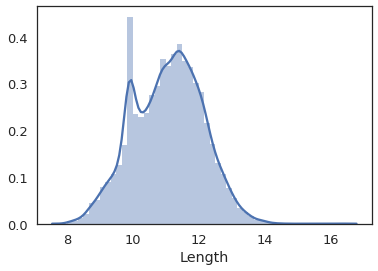

In [10]:
# Filter small mRNAs (transcriptsdd with length < 250 - mostly snoRNAs)
rpkm = rpkm.loc[rpkm.Length >= 250, :]
sns.distplot(np.log2(rpkm.Length + 1))

### Create sample datasheet

In [11]:
samples = pd.Series(rpkm.iloc[:, 7:].columns.values)
cage = samples.str.split('_').str[-1]
group = ['_'.join(i) for i in samples.str.split('_').str[:-1]]

samplesDF = pd.DataFrame([pd.Series(samples),
              pd.Series(cage),
              pd.Series(group)],
              index=['sample', 'cage', 'group']).T


### Convert to tpm

In [12]:
rpkm_mat = rpkm.iloc[:, 7:]
rpkm_mat['gene'] = mm10_gene
rpkm_mat = rpkm_mat.reset_index().set_index('gene').drop(labels='refseqID', axis=1)
tpm_mat = (rpkm.iloc[:, 7:] / rpkm.iloc[:, 7:].sum()) * 1000000

In [13]:
# create avg tpm matrix for filtering
tpm_avg = pd.DataFrame([
    tpm_mat.loc[:, list(samplesDF.group.str.contains('AMLNDiet_10week'))].mean(1),
    tpm_mat.loc[:, list(samplesDF.group.str.contains('AMLNDiet_21week'))].mean(1),
    tpm_mat.loc[:, list(samplesDF.group.str.contains('AMLNDiet_28week'))].mean(1),
    tpm_mat.loc[:, list(samplesDF.group.str.contains('AMLNDiet_30week'))].mean(1),
    tpm_mat.loc[:, list(samplesDF.group.str.contains('Control_6week'))].mean(1),
    tpm_mat.loc[:, list(samplesDF.group.str.contains('Control_21week'))].mean(1),
    tpm_mat.loc[:, list(samplesDF.group.str.contains('Control_28wk|Control_30week'))].mean(1)],
    index=['AMLNDiet_10week', 'AMLNDiet_21week', 'AMLNDiet_28week',
           'AMLNDiet_30week', 'Control_6week', 'Control_21week',
           'Control_30week']).T

# filter genes not expressed at least 4 tpm in any sample
tpm_filt = tpm_mat.loc[(tpm_avg > 4).any(1), :]

# change index to gene names
tpm_filt = tpm_filt.merge(mm10_refseq, how='left', left_index=True, right_index=True).drop_duplicates()
tpm_filt = tpm_filt.reset_index().set_index('gene').drop(columns='index')

# sort columns (manually for now)
cols = tpm_filt.columns.values
tpm_mat_filt = tpm_filt.reindex([# 0 week control cols[9],
                      cols[14], cols[15], cols[16], cols[17],
                      # 21wk controls cols[10], cols[11],
                      # 30wk controls cols[13], cols[12],
                      cols[0], cols[1], cols[2],
                      cols[3], cols[4], cols[5],
                      cols[6], cols[7], cols[8]],
                      axis=1)

tpm_mat_zscore = tpm_mat_filt.apply(lambda x: (x - x.mean()) / x.std(), axis=1)

# Descriptive analysis of our data

In [14]:
# Import packages for PCA analysis
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA # uses SVD

In [15]:
# standardize matrix, mean=0, std=1
rpkm_std = StandardScaler().fit_transform(rpkm.iloc[:, 7:])
# run PCA
pca = PCA(n_components=3)
tpm_pca = pca.fit_transform(rpkm_std.T)
exp_var = pca.explained_variance_ratio_
#create df for plotting
tpm_pca_df = pd.DataFrame(tpm_pca, columns=['PC1', 'PC2', 'PC3'],
        index=([samplesDF.group])).reset_index()
tpm_pca_df['cage'] = samplesDF['cage']

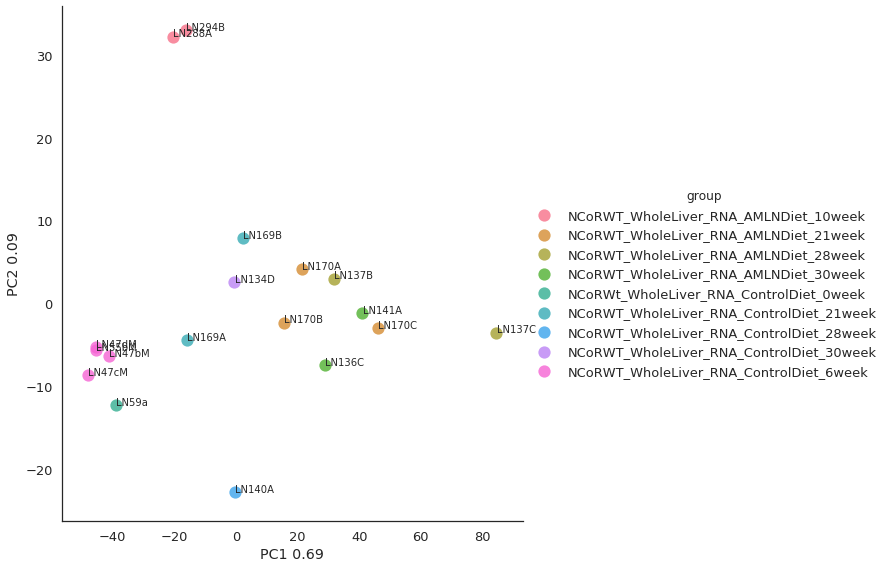

In [16]:
ax = sns.lmplot('PC1', 'PC2', tpm_pca_df, fit_reg=False,
                hue='group', # palette=color_dict,
                size=8, scatter_kws={'s': 150},
                legend=True)
ax.set(xlabel=('PC1 %.2f' % exp_var[0]), ylabel=('PC2 %.2f' % exp_var[1]))
label_point(tpm_pca_df.PC1, tpm_pca_df.PC2, tpm_pca_df.cage, plt.gca())

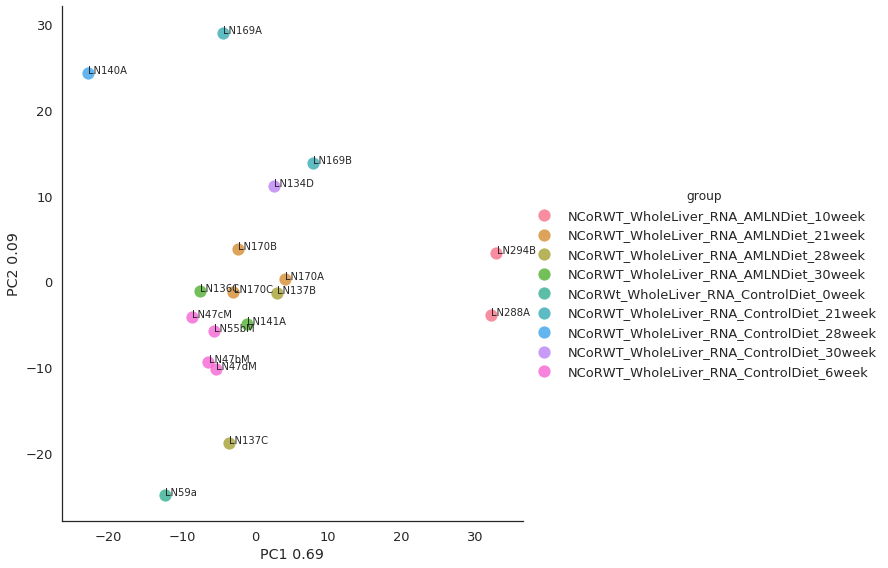

In [17]:
ax = sns.lmplot('PC2', 'PC3', tpm_pca_df, fit_reg=False,
                hue='group', # palette=color_dict,
                size=8, scatter_kws={'s': 150})
ax.set(xlabel=('PC1 %.2f' % exp_var[0]), ylabel=('PC2 %.2f' % exp_var[1]))
label_point(tpm_pca_df.PC2, tpm_pca_df.PC3, tpm_pca_df.cage, plt.gca())

In [18]:
transcript_pc = pd.DataFrame(pca.components_.T, rpkm.index, columns=['PC1','PC2','PC3'])

In [19]:
# look at the genes with the highest loading in PC1
transcript_pc.sort_values(by = 'PC1', ascending=False).head(10)

,PC1,PC2,PC3
refseqID,,,
NM_001305844,0.639226,-0.023278,0.016928
NM_013474,0.208901,0.451802,0.009600
NM_001329965,0.137242,-0.182929,-0.046652
NM_133977,0.117296,-0.223166,-0.163537
NM_009127,0.087444,0.087304,-0.109762
NM_007468,0.087317,-0.203038,0.427425
NM_010239,0.078864,-0.043301,-0.015479
NM_011255,0.064058,0.027559,0.093542
NM_001329527,0.055572,-0.008949,-0.038755


### Heatmap

/home/h1bennet/anaconda3/envs/deseq/lib/python3.6/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


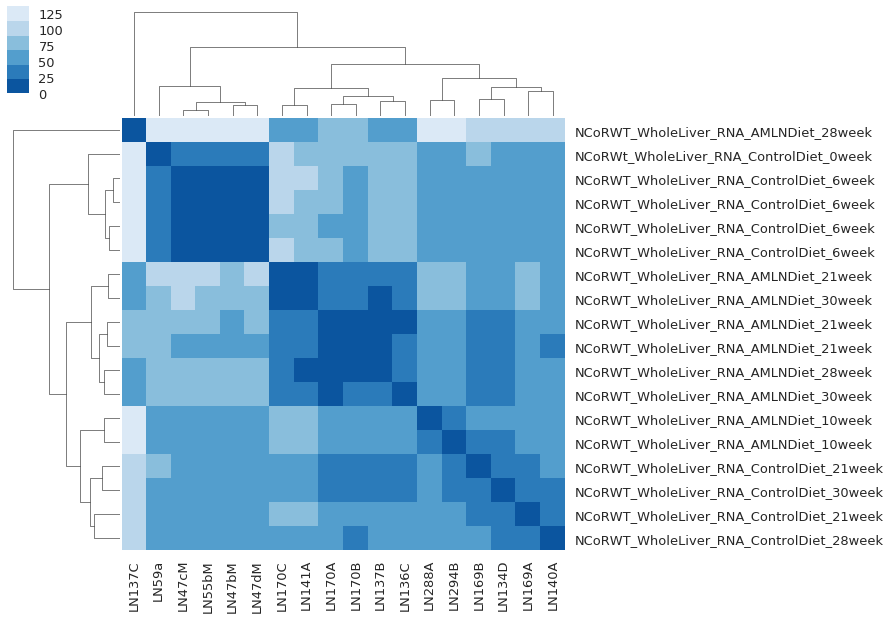

In [20]:
from scipy.spatial import distance
rpkm_dist = pd.DataFrame(distance.squareform(distance.pdist(rpkm_std.T, 'euclidean')),
                        columns = list(samplesDF.cage),
                        index = list(samplesDF.group))
# plot values using sns clustermap - ignore error as we know we are putting in a distance mat
g = sns.clustermap(rpkm_dist, cmap=sns.color_palette("Blues_r"))

### Cluster most variable genes - top 10k, 1k

In [21]:
var_rank = tpm_mat_filt.var(1).rank(ascending=False)


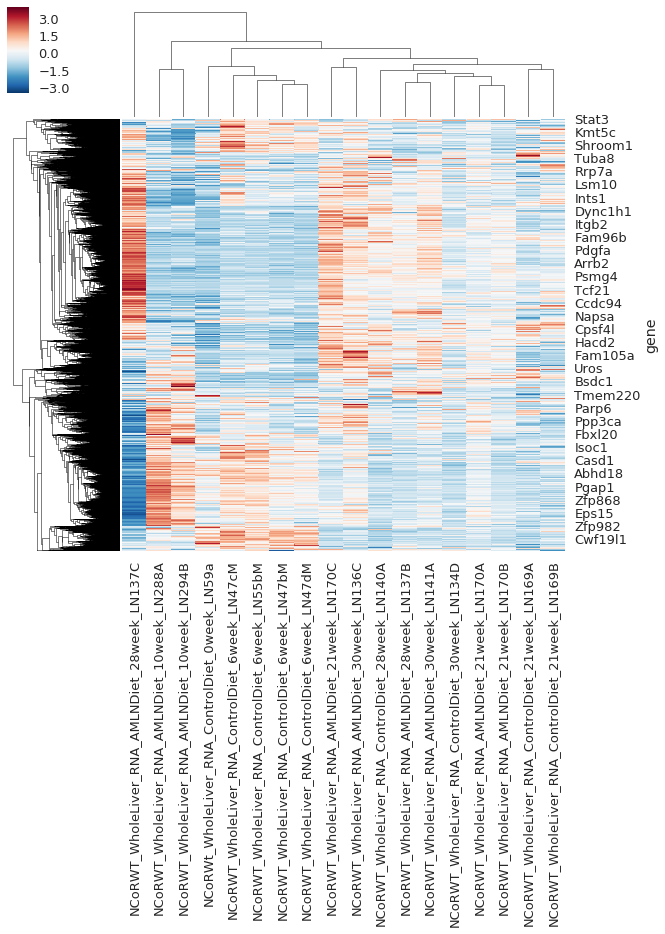

In [22]:
sns.clustermap(
    tpm_filt.loc[var_rank <= 10000, :],
    z_score=0,
    cmap='RdBu_r')
    # col_cluster=False)

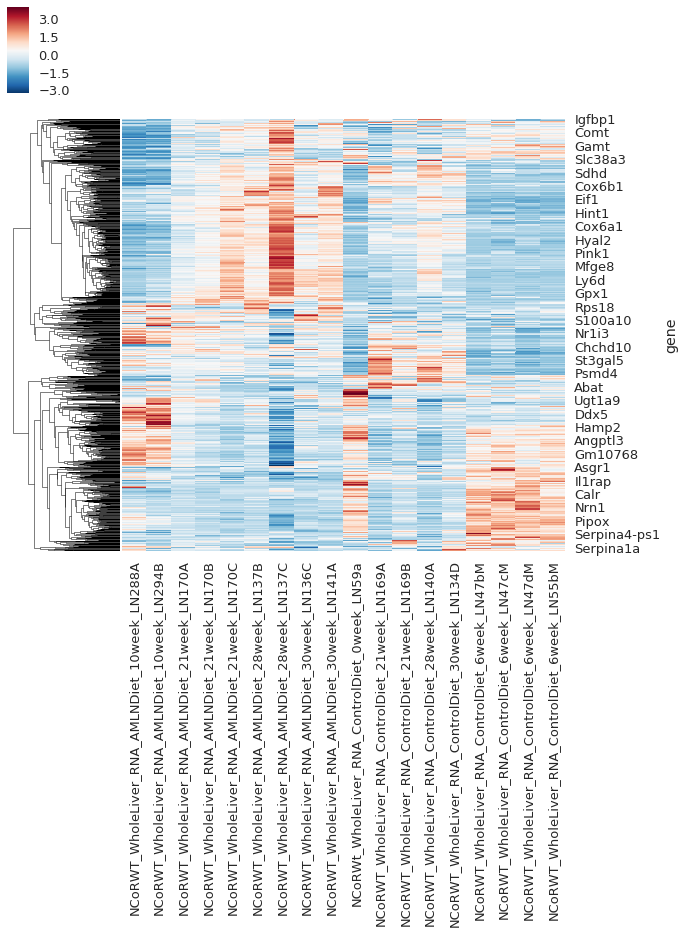

In [64]:
sns.clustermap(
    tpm_filt.loc[var_rank <= 1000, :],
    z_score=0,
    cmap='RdBu_r',
    col_cluster=False)

# Diff Gene Analysis

In [24]:
def pull_comparision(diff_gene, comp):
    return diff_gene.loc[:, [comp + ' Log2 Fold Change',
                            comp + ' p-value',
                            comp + ' adj. p-value']]

In [25]:
# extract groups
comp_dict = {}
pattern='(\w* vs. \w*).*'
for col in diff_gene.columns.values:
    m = re.search(string=col, pattern=pattern)
    if m:
        df = pull_comparision(diff_gene, m.group(1))
        df.columns = ['log2fc', 'pval', 'adj_pval']
        comp_dict[re.sub('G0[0-9]_', '', m.group(1))] = df  

### Set p value and fc cutoffs

In [26]:
#### Write gene list for analysis with metascape
pval = 0.01 # p value cutoff
fc = 1 # fc cutoff for interesting genes
fc_max = 1.3 # max fc to define as unchanged

### explore genes that are up at each time point relative to control
_____
Easiest way to do this: pick out significantly upregulated genes at 1wk then ones that have low fold change (maybe w/in 1.3?) between 1 week and all other samples

In [27]:
comp_dict.keys()

dict_keys(['10wk vs. 21wk', '10wk vs. 28wk', '10wk vs. 30wk', '10wk vs. 0wk_control', '10wk vs. 21wk_control', '10wk vs. 30wk_control', '10wk vs. 6wk_control', '21wk vs. 28wk', '21wk vs. 30wk', '21wk vs. 0wk_control', '21wk vs. 21wk_control', '21wk vs. 30wk_control', '21wk vs. 6wk_control', '28wk vs. 30wk', '28wk vs. 0wk_control', '28wk vs. 21wk_control', '28wk vs. 30wk_control', '28wk vs. 6wk_control', '30wk vs. 0wk_control', '30wk vs. 21wk_control', '30wk vs. 30wk_control', '30wk vs. 6wk_control', '0wk_control vs. 21wk_control', '0wk_control vs. 30wk_control', '0wk_control vs. 6wk_control', '21wk_control vs. 30wk_control', '21wk_control vs. 6wk_control', '30wk_control vs. 6wk_control'])

In [28]:
#### Write gene list for analysis with metascape
pval = 0.01 # p value cutoff
fc = 1 # fc cutoff for interesting genes
fc_max = 1.3 # max fc to define as unchanged

# 10 weeks

In [39]:
tenwk_up = ( comp_dict['10wk vs. 6wk_control'].adj_pval <= pval ) & \
( comp_dict['10wk vs. 0wk_control'].log2fc <= -fc )

tenwk_dn = ( comp_dict['10wk vs. 6wk_control'].adj_pval <= pval ) & \
( comp_dict['10wk vs. 0wk_control'].log2fc >= fc )

with open('./expression_liver/tim4pos_10wk_up_fc2_p01.txt', 'w') as f:
    for val in tenwk_up[tenwk_up].index.values:
        f.write(val+'\n')
f.close()

with open('./expression_liver//tim4pos_10wk_dn_fc2_p01.txt', 'w') as f:
    for val in tenwk_dn[tenwk_dn].index.values:
        f.write(val+'\n')
f.close()

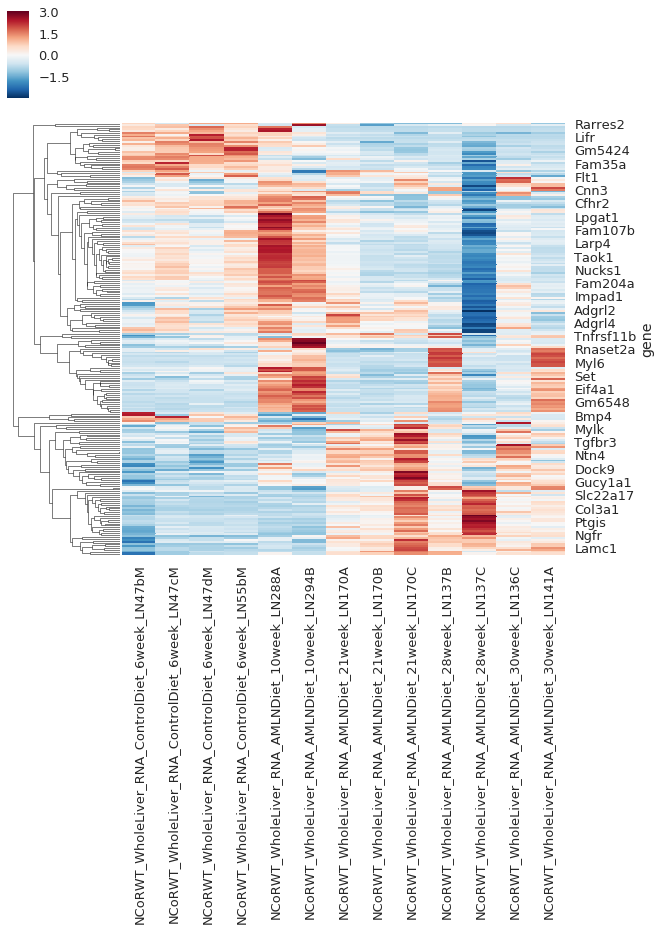

In [38]:
sns.clustermap(
    tpm_mat_filt[tpm_mat_filt.index.isin(onewk_up[onewk_up].index.values)],
    z_score=0,
    cmap='RdBu_r',
    col_cluster=False)

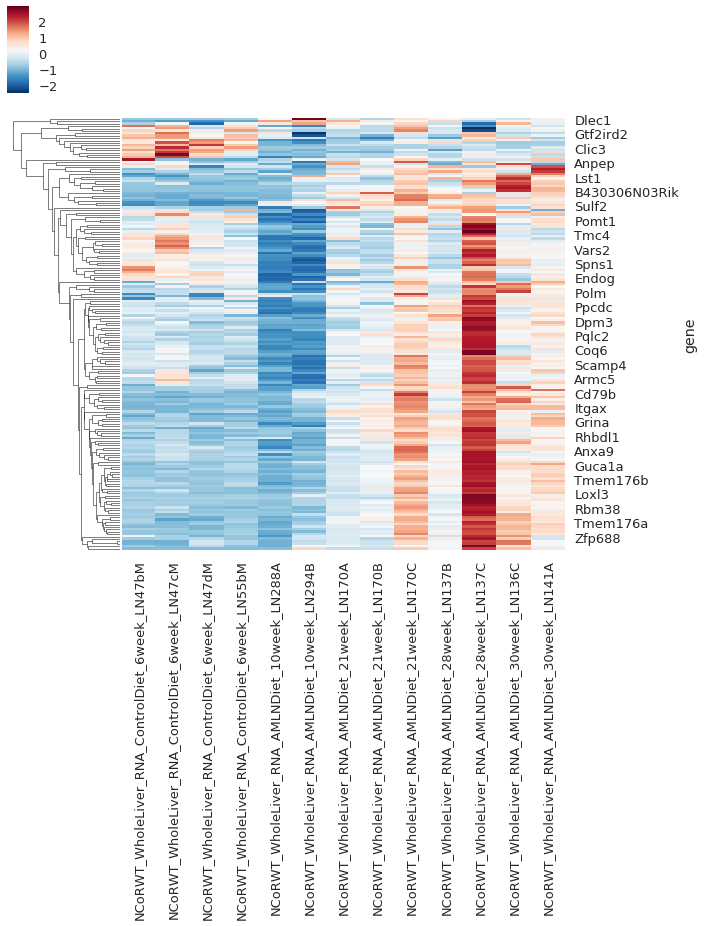

In [37]:
sns.clustermap(
    tpm_mat_filt[tpm_mat_filt.index.isin(onewk_dn[onewk_dn].index.values)],
    z_score=0,
    cmap='RdBu_r',
    col_cluster=False)

# 21 weeks

In [31]:
twentyonewk_up = ( comp_dict['10wk vs. 21wk'].adj_pval <= pval ) & \
( comp_dict['10wk vs. 0wk_control'].log2fc <= -fc )

twentyonewk_dn = ( comp_dict['10wk vs. 21wk'].adj_pval <= pval ) & \
( comp_dict['10wk vs. 0wk_control'].log2fc >= fc )

with open('./expression_liver/tim4pos_21wk_up_fc2_p01.txt', 'w') as f:
    for val in twentyonewk_up[twentyonewk_up].index.values:
        f.write(val+'\n')
f.close()

with open('./expression_liver//tim4pos_21wk_dn_fc2_p01.txt', 'w') as f:
    for val in twentyonewk_dn[twentyonewk_dn].index.values:
        f.write(val+'\n')
f.close()

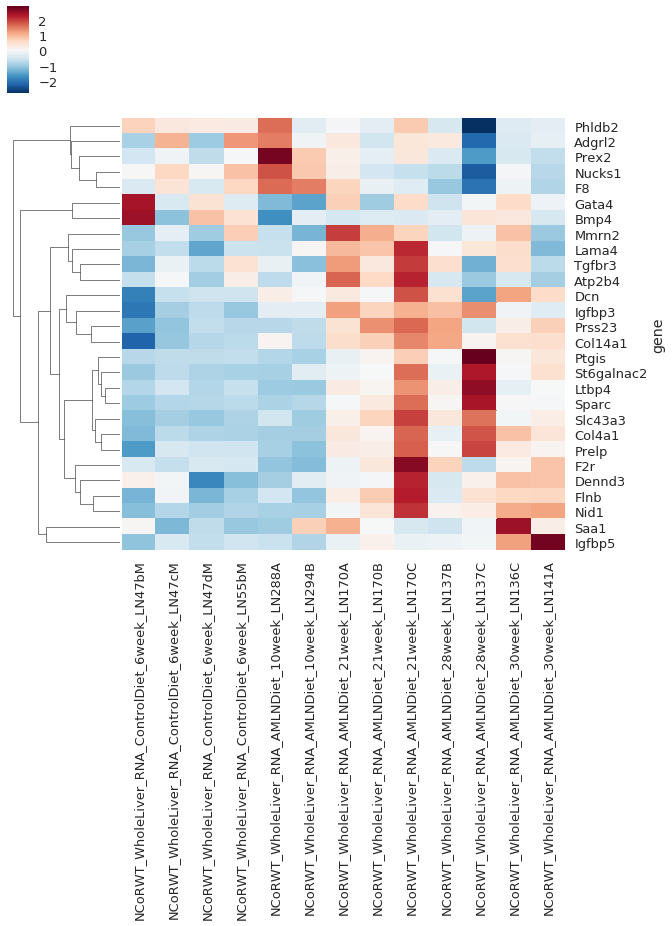

In [32]:
sns.clustermap(
    tpm_mat_filt[tpm_mat_filt.index.isin(twentyonewk_up[twentyonewk_up].index.values)],
    z_score=0,
    cmap='RdBu_r',
    col_cluster=False)

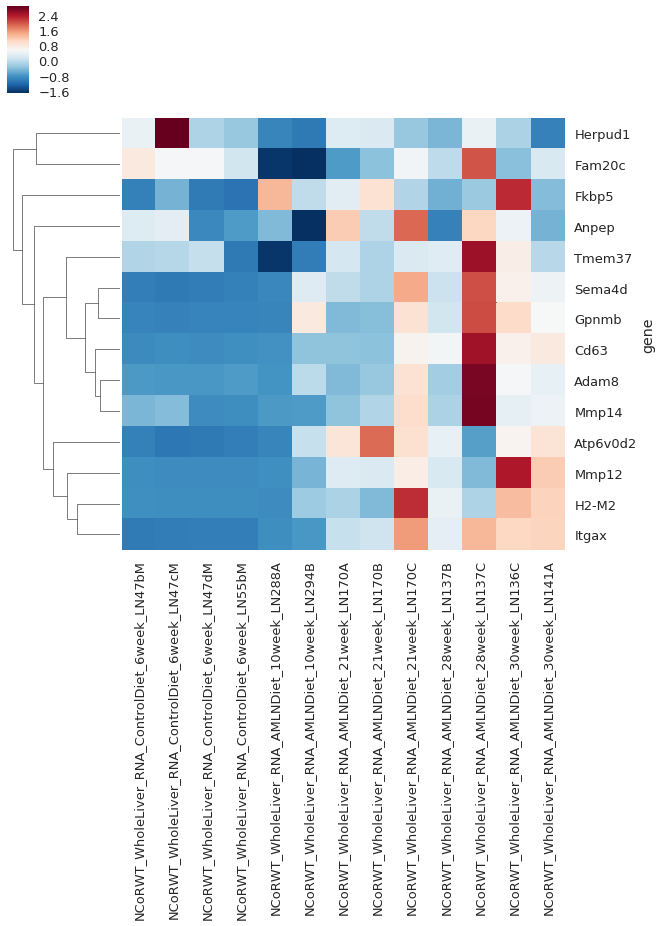

In [33]:
sns.clustermap(
    tpm_mat_filt[tpm_mat_filt.index.isin(twentyonewk_dn[twentyonewk_dn].index.values)],
    z_score=0,
    cmap='RdBu_r',
    col_cluster=False)

# 28 week NASH

In [34]:
comp_dict.keys()

dict_keys(['10wk vs. 21wk', '10wk vs. 28wk', '10wk vs. 30wk', '10wk vs. 0wk_control', '10wk vs. 21wk_control', '10wk vs. 30wk_control', '10wk vs. 6wk_control', '21wk vs. 28wk', '21wk vs. 30wk', '21wk vs. 0wk_control', '21wk vs. 21wk_control', '21wk vs. 30wk_control', '21wk vs. 6wk_control', '28wk vs. 30wk', '28wk vs. 0wk_control', '28wk vs. 21wk_control', '28wk vs. 30wk_control', '28wk vs. 6wk_control', '30wk vs. 0wk_control', '30wk vs. 21wk_control', '30wk vs. 30wk_control', '30wk vs. 6wk_control', '0wk_control vs. 21wk_control', '0wk_control vs. 30wk_control', '0wk_control vs. 6wk_control', '21wk_control vs. 30wk_control', '21wk_control vs. 6wk_control', '30wk_control vs. 6wk_control'])

In [37]:
twentyeightwk_up = ( comp_dict['21wk vs. 28wk'].adj_pval <= pval ) & \
( comp_dict['10wk vs. 0wk_control'].log2fc >= fc )

twentyeightwk_dn = ( comp_dict['21wk vs. 28wk'].adj_pval <= pval ) & \
( comp_dict['10wk vs. 0wk_control'].log2fc <= -fc )

with open('./expression_liver/tim4pos_21wk_up_fc2_p01.txt', 'w') as f:
    for val in twentyeightwk_up[twentyeightwk_up].index.values:
        f.write(val+'\n')
f.close()

with open('./expression_liver//tim4pos_21wk_dn_fc2_p01.txt', 'w') as f:
    for val in twentyeightwk_dn[twentyeightwk_dn].index.values:
        f.write(val+'\n')
f.close()

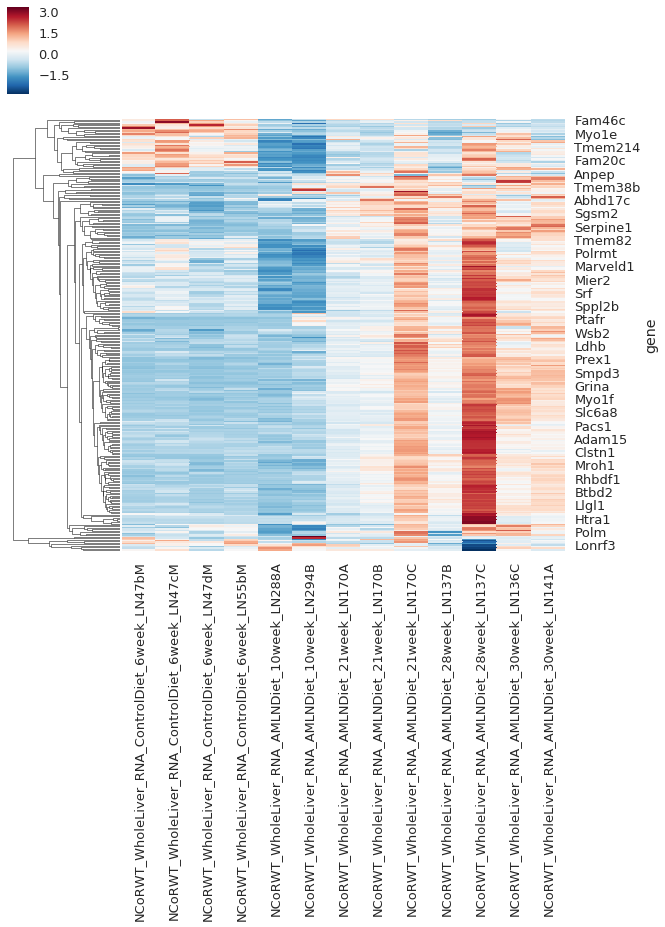

In [38]:
sns.clustermap(
    tpm_mat_filt[tpm_mat_filt.index.isin(twentyeightwk_up[twentyeightwk_up].index.values)],
    z_score=0,
    cmap='RdBu_r',
    col_cluster=False)

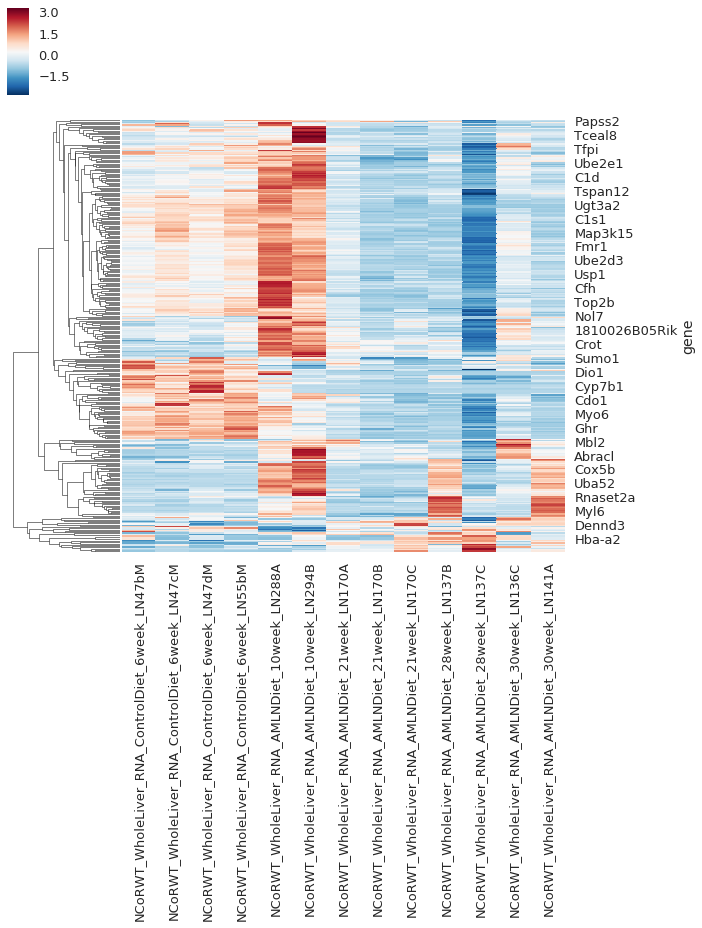

In [39]:
sns.clustermap(
    tpm_mat_filt[tpm_mat_filt.index.isin(twentyeightwk_dn[twentyeightwk_dn].index.values)],
    z_score=0,
    cmap='RdBu_r',
    col_cluster=False)

In [45]:
deseq_4wk = pd.read_csv('../180412_RNA_4wk/rnaseq_c57bl6_amln_4wk_deseq_results.txt',
                        sep=',', index_col=0).merge(mm10_refseq,
                                                    left_index=True,
                                                    right_index=True,
                                                    how='left')
deseq_1wk = pd.read_csv('../180412_RNA_4wk/rnaseq_c57bl6_amln_1wk_deseq_results.txt',
                        sep=',', index_col=0).merge(mm10_refseq,
                                                    left_index=True,
                                                    right_index=True,
                                                    how='left')

# read in 1 wk vs 4 wk DESeq2 table
deseq_4wk_1wk = pd.read_csv('../180412_RNA_4wk/rnaseq_c57bl6_amln_4wk_1wk_deseq_results.txt',
                            sep=',', index_col=0).merge(mm10_refseq,
                                                    left_index=True,
                                                    right_index=True,
                                                    how='left')

### Set p value and fc cutoffs

In [46]:
#### Write gene list for analysis with metascape
pval = 0.01 # p value cutoff
fc = 1 # fc cutoff for interesting genes

### 4 week diet effect

In [47]:
# get gene lists
c57bl6_amln_4wk_deseq_p01_fc2_up = deseq_4wk.loc[
        ((deseq_4wk.padj <= pval) & (deseq_4wk.log2FoldChange > fc)), 'gene']

c57bl6_amln_4wk_deseq_p01_fc2_dn = deseq_4wk.loc[
        ((deseq_4wk.padj <= pval) & (deseq_4wk.log2FoldChange < -fc)), 'gene']

# write output for uploading to metascape
f = open('./gene_lists/c57bl6_amln_4wk_deseq_p01_fc2_up_genes.txt', 'w')
gene_list = '\n'.join(['geneID'] +  c57bl6_amln_4wk_deseq_p01_fc2_up.tolist())
f.write(gene_list)
f.close()

f = open('./gene_lists/c57bl6_amln_4wk_deseq_p01_fc2_dn_genes.txt', 'w')
gene_list = '\n'.join(['geneID'] +  c57bl6_amln_4wk_deseq_p01_fc2_dn.tolist())
f.write(gene_list)
f.close()

### 1 week diet effect

In [48]:
#### Write gene list for analysis with metascape
pval = 0.01 # p value cutoff
fc = 1 # fc cutoff for interesting genes

# get gene lists
c57bl6_amln_1wk_deseq_p01_fc2_up = deseq_1wk.loc[
        ((deseq_1wk.padj <= pval) & (deseq_1wk.log2FoldChange > fc)), 'gene']

c57bl6_amln_1wk_deseq_p01_fc2_dn = deseq_1wk.loc[
        ((deseq_1wk.padj <= pval) & (deseq_1wk.log2FoldChange < -fc)), 'gene']

# write output for uploading to metascape
f = open(outdir + './gene_lists/c57bl6_amln_1wk_deseq_p01_fc2_up_genes.txt', 'w')
gene_list = '\n'.join(['geneID'] +  c57bl6_amln_1wk_deseq_p01_fc2_up.tolist())
f.write(gene_list)
f.close()

f = open(outdir + './gene_lists/c57bl6_amln_1wk_deseq_p01_fc2_dn_genes.txt', 'w')
gene_list = '\n'.join(['geneID'] +  c57bl6_amln_1wk_deseq_p01_fc2_dn.tolist())
f.write(gene_list)
f.close()

### 4 vs 1 week diet effect

In [49]:
#### Write gene list for analysis with metascape
pval = 0.01 # p value cutoff
fc = 1 # fc cutoff for interesting genes

# get gene lists
c57bl6_amln_4wk_1wk_deseq_p01_fc2_up = deseq_4wk_1wk.loc[
        ((deseq_4wk_1wk.padj <= pval) & (deseq_4wk_1wk.log2FoldChange > fc)), 'gene']

c57bl6_amln_4wk_1wk_deseq_p01_fc2_dn = deseq_4wk_1wk.loc[
        ((deseq_4wk_1wk.padj <= pval) & (deseq_4wk_1wk.log2FoldChange < -fc)), 'gene']

# write output for uploading to metascape
f = open(outdir + './gene_lists/c57bl6_amln_4wk_1wk_deseq_p01_fc2_up_genes.txt', 'w')
gene_list = '\n'.join(['geneID'] +  c57bl6_amln_4wk_1wk_deseq_p01_fc2_up.tolist())
f.write(gene_list)
f.close()

f = open(outdir + './gene_lists/c57bl6_amln_4wk_1wk_deseq_p01_fc2_dn_genes.txt', 'w')
gene_list = '\n'.join(['geneID'] +  c57bl6_amln_4wk_1wk_deseq_p01_fc2_dn.dropna().tolist())
f.write(gene_list)
f.close()

# Comparing Differential Gene Expression

In [50]:
tpm_mat = (rpkm.iloc[:, 7:] / rpkm.iloc[:, 7:].sum()) * 1000000

In [77]:
# filter genes not expressed at least 1 tpm across more than half of samples
tpm_mat_filt = tpm_mat.loc[tpm_mat.mean(axis=1) > 10, :]

# change index to gene names
tpm_mat_filt = tpm_mat_filt.merge(mm10_refseq, how='left', left_index=True, right_index=True).drop_duplicates()
tpm_mat_filt = tpm_mat_filt.reset_index().set_index('gene').drop(columns='index')

# sort columns (manually for now)
cols = tpm_mat_filt.columns.values
tpm_mat_filt = tpm_mat_filt.reindex([cols[10], cols[11], cols[12],
                      cols[0], cols[1], cols[8],
                      cols[9], cols[2], cols[3],
                      cols[4], cols[5], cols[6],
                      cols[7]], axis=1)

Lets just look at the ge patterns for 1 week differential genes

1334


/home/h1bennet/anaconda3/envs/deseq/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  import sys
/home/h1bennet/anaconda3/envs/deseq/lib/python3.6/site-packages/pandas/core/indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


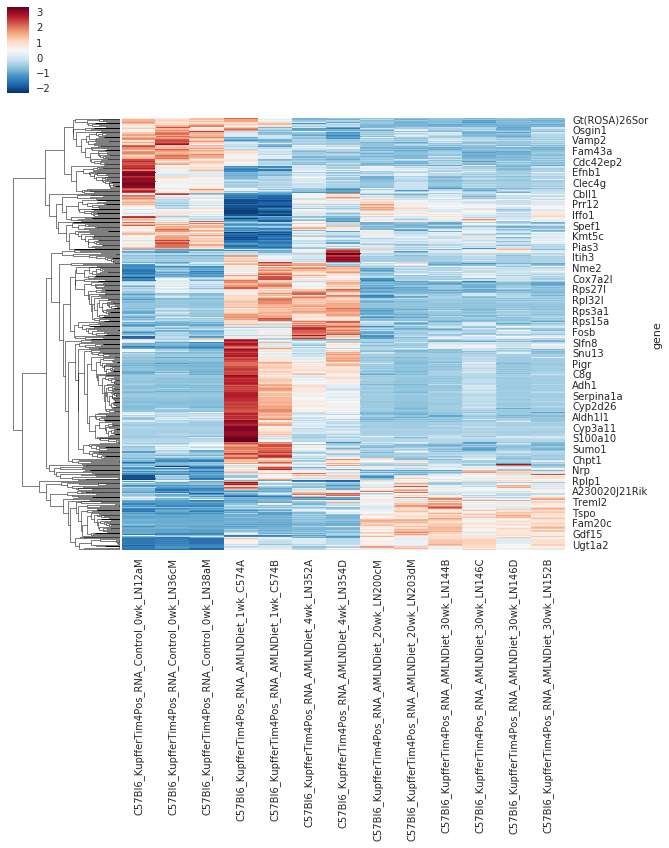

In [87]:
x = list(c57bl6_amln_1wk_deseq_p01_fc2_dn)
x.extend(list(c57bl6_amln_1wk_deseq_p01_fc2_up))
x.extend(list(c57bl6_amln_4wk_deseq_p01_fc2_up))
x.extend(list(c57bl6_amln_4wk_deseq_p01_fc2_dn))
x = set(x)
print(len(x))
sns.clustermap(tpm_mat_filt.loc[x, :].dropna(), z_score=0, cmap='RdBu_r', col_cluster=False)

Lets call DE genes on 30 week and 20 week then take ones that are significant at any time point then look at the FC pattern.

### What about genes that are downregulated and stay low

/home/h1bennet/anaconda3/envs/deseq/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.
/home/h1bennet/anaconda3/envs/deseq/lib/python3.6/site-packages/pandas/core/indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


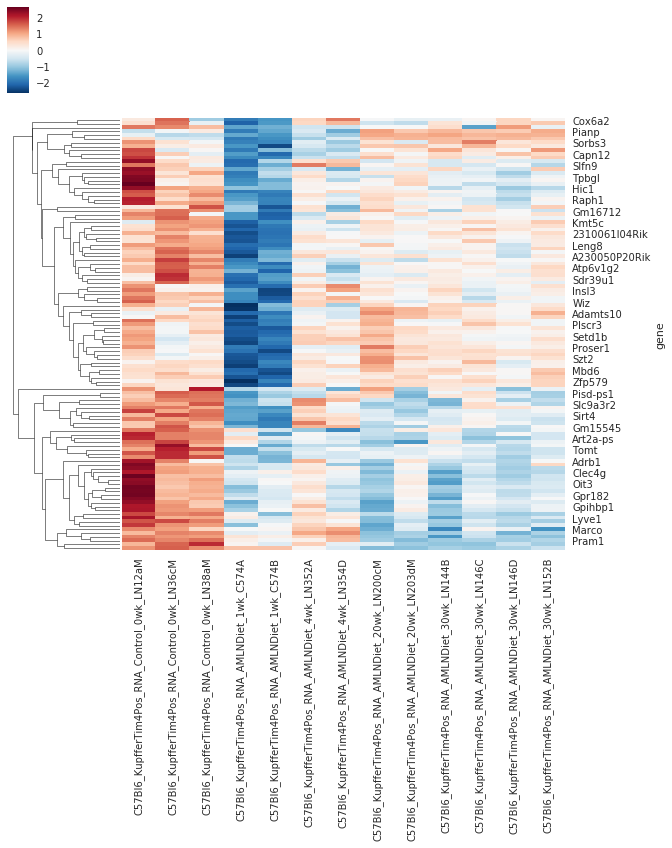

In [86]:
sns.clustermap(np.log2(tpm_mat_filt.loc[c57bl6_amln_1wk_deseq_p01_fc2_dn, :].dropna() + 1), z_score=0, cmap='RdBu_r', col_cluster=False)

How many genes go up then down week 1 to 4 vs down to up week 1 to 4?

In [52]:
deseq_down_up = list(set(c57bl6_amln_1wk_deseq_p01_fc2_dn).intersection(c57bl6_amln_4wk_1wk_deseq_p01_fc2_up))
deseq_down_up_refseq = mm10_refseq.loc[[(gene in deseq_down_up) for gene in mm10_refseq.gene], :].index.tolist()

deseq_up_down = list(set(c57bl6_amln_1wk_deseq_p01_fc2_up).intersection(c57bl6_amln_4wk_1wk_deseq_p01_fc2_dn))
deseq_up_down_refseq = mm10_refseq.loc[[(gene in deseq_up_down) for gene in mm10_refseq.gene], :].index.tolist()

In [53]:
print(len(c57bl6_amln_1wk_deseq_p01_fc2_dn))
print(len(c57bl6_amln_4wk_1wk_deseq_p01_fc2_up))
print(len(deseq_down_up))

314
125
49


In [54]:
print(len(c57bl6_amln_1wk_deseq_p01_fc2_up))
print(len(c57bl6_amln_4wk_1wk_deseq_p01_fc2_dn))
print(len(deseq_up_down))

805
209
122


/home/h1bennet/anaconda3/envs/deseq/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  
/home/h1bennet/anaconda3/envs/deseq/lib/python3.6/site-packages/pandas/core/indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


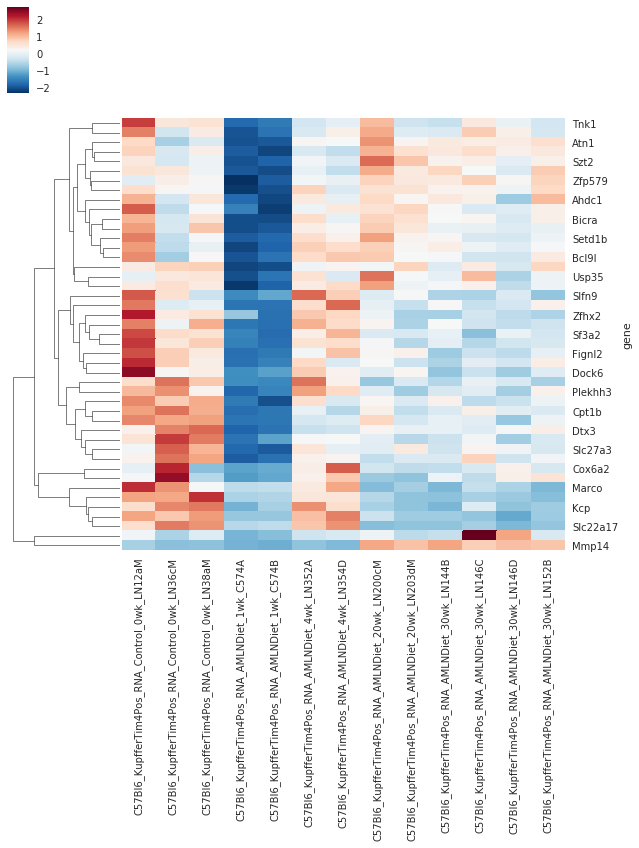

In [55]:
sns.clustermap(tpm_mat_filt.loc[deseq_down_up, :].dropna(), z_score=0, cmap='RdBu_r', col_cluster=False)

* Slc27a3 is a long chain fatty acid metabolic compount (acyl-CoA ligase) in mitochondrial beta oxidation gene, FA + CoA +ATP --> Acyl-CoA + AMP. Maybe 1 week KCs are turning off beta oxidation?
* Cpt1b rate controlling enzyme of long chain fatty acid beta oxidation, transports FA into mitochondria from cytoplasm
* Spred3 and Tnk1 both negatively regulate the MAPK pathway
* Setd1b is part of HMT complex that trimethylates H3 at Lys4
* Adgrg6 activated by type IV collagen
* Atn is transcriptional corepressor. Phf21b is a TF. Maml3 is a NOTCH coactivator
* FBRS induces fibroblasts proliferation
* Col11a2 and Col7a1 collagen compounds (obviously), mmp14 breaks down collagen
* Marco is classic KC gene - scavenger receptor for gram negative and gram positive bacteria
* Kcp inhibits TGFB signaling

In [35]:
sns.set(font_scale=1)
sns.clustermap(tpm_mat_filt.loc[deseq_up_down, :].dropna(), z_score=0, cmap='RdBu_r', col_cluster=False)

NameError: name 'deseq_up_down' is not defined

In [36]:
', '.join(deseq_up_down)

NameError: name 'deseq_up_down' is not defined

* Mapkapk3 activated by map kinase. Phosphorylates inflammatory genes
* Ifi205 activates NLRP3 inflammasome in resposne to
* Hsd3b5 is a steroid biosynthesis pathway enzyme, Cyp4a12 is a steroid oxidizer
* Cyp2c mice involved  in conjugation and creation of bile acids.
* Rdh7 is involved in retinol metabolism

### How do KC Specific Genes change

/home/h1bennet/anaconda3/envs/deseq/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  after removing the cwd from sys.path.
/home/h1bennet/anaconda3/envs/deseq/lib/python3.6/site-packages/pandas/core/indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


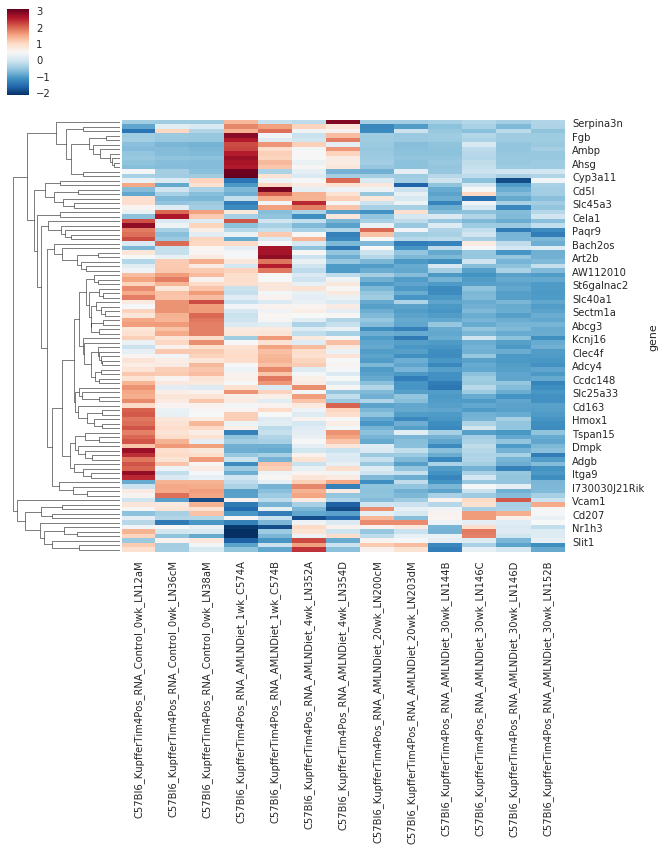

In [90]:
with open('/home/h1bennet/liverStrains/data/mouse/KC_Specific_Genes150.txt', 'r') as f:
    kc_genes = f.read().split()
    
sns.clustermap(tpm_mat_filt.loc[kc_genes, :].dropna(),
               z_score=0, cmap='RdBu_r', col_cluster=False)

/home/h1bennet/anaconda3/envs/deseq/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.
/home/h1bennet/anaconda3/envs/deseq/lib/python3.6/site-packages/pandas/core/indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


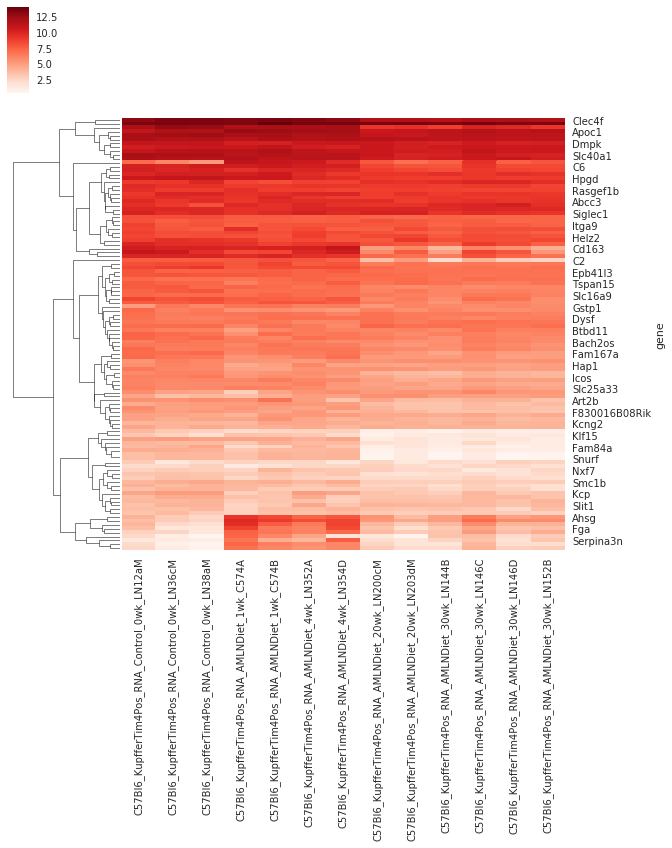

In [38]:
sns.clustermap(np.log2(tpm_mat_filt.loc[kc_genes, :].dropna() + 1),
               cmap='Reds', col_cluster=False)

In [39]:
de_sermut_genes = ['Nnmt', 'Hamp2', 'Thrsp',
                   'Ppp1r3g', 'Cyp2c69', 'Cyp2b13',
                   'Cyp2b9', 'Ces1f', 'Slc22a26',
                   'Bex1', 'Syngr1', 'Wfdc3',
                   'Fabp5', 'Timp1', 'Atp06vd2',
                   'Scara3', 'Obspl3', 'Cx3cr1',
                   'Col1a1', 'Spp1', 'Osbpl3',
                   'Acss3', 'Elovl3', 'Fads1',
                   'Fads2', 'Elovl5', 'Ascl1',
                   'Acox1', 'Acaa1b', 'Acad11',
                   'Acadm']

Plot genes from the mutated serine mice in the Becares et al 2017 BioRXiv paper.

Of the ones with a name that matches our gene name we see that genes that were downregulated by removing the phosphate group are upregulated in the later stages of NASH!

/home/h1bennet/anaconda3/envs/deseq/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.
/home/h1bennet/anaconda3/envs/deseq/lib/python3.6/site-packages/pandas/core/indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


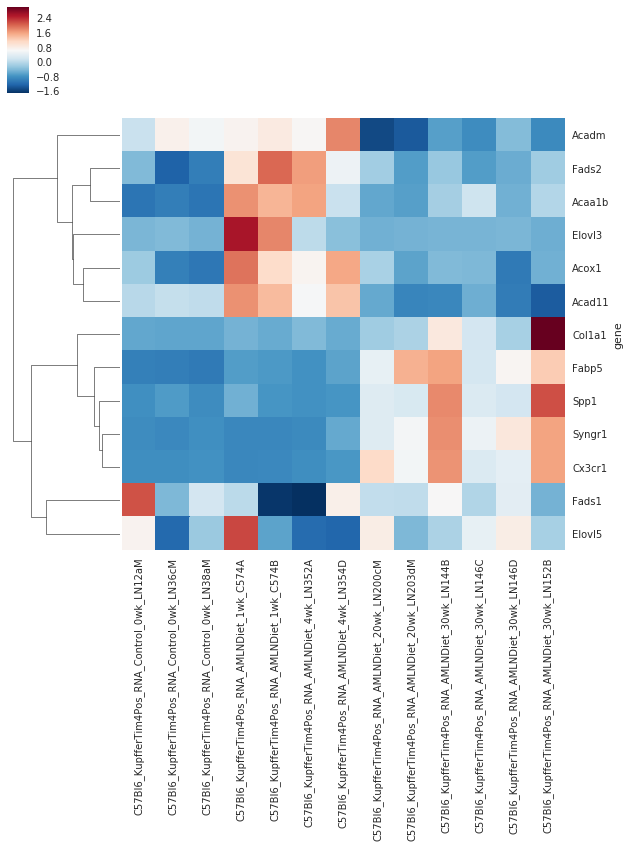

In [40]:
sns.clustermap(tpm_mat_filt.loc[de_sermut_genes, :].dropna(),
               z_score=0, cmap='RdBu_r', col_cluster=False)